# Model Training for Reduction of Area Prediction

This notebook trains multiple regression models on PCA-transformed data and compares their performance using GridSearchCV with 5-fold cross-validation.

**Reduction of Area (%)** measures ductility - the percentage decrease in cross-sectional area at the fracture point of a welded specimen. It's a critical quality indicator for material toughness and structural integrity.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
os.makedirs('trained_models', exist_ok=True)

In [3]:
df = pd.read_csv('transformed_data/welddb_pca_reduction_area.csv')
print(f"Dataset shape: {df.shape}")

Dataset shape: (705, 18)


In [4]:
X = df.drop('Reduction_Area_%', axis=1)
y = df['Reduction_Area_%']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 564
Testing samples: 141


## Model Definitions

In [5]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42, verbosity=-1),
    'SVR': SVR()
}

In [6]:
param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'DecisionTree': {
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [4, 8, 12]
    },
    'RandomForest': {
        'n_estimators': [200, 300],
        'max_depth': [15, 20, 25],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt']
    },
    'GradientBoosting': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6],
        'subsample': [0.8, 0.9],
        'min_samples_split': [5, 10]
    },
    'XGBoost': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6, 7],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [1, 3]
    },
    'LightGBM': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [5, 7, 9],
        'num_leaves': [50, 70],
        'subsample': [0.8, 0.9],
        'min_child_samples': [20, 30]
    },
    'SVR': {
        'C': [1, 10, 50],
        'kernel': ['rbf'],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.1, 0.2]
    }
}

## Train Models with GridSearchCV

In [7]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Best_Params': str(grid_search.best_params_),
        'CV_Score': grid_search.best_score_,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse
    })
    
    joblib.dump(grid_search.best_estimator_, f'trained_models/{name}_model.pkl')
    
    print(f"  CV R²: {grid_search.best_score_:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Train R²: {train_r2:.4f}")
    print()

Training Ridge...
  CV R²: 0.5832
  Test R²: 0.6708
  Train R²: 0.6176

Training Lasso...
  CV R²: 0.5819
  Test R²: 0.6751
  Train R²: 0.6159

Training ElasticNet...
  CV R²: 0.5832
  Test R²: 0.6708
  Train R²: 0.6176

Training Lasso...
  CV R²: 0.5819
  Test R²: 0.6751
  Train R²: 0.6159

Training ElasticNet...
  CV R²: 0.5753
  Test R²: 0.6699
  Train R²: 0.6041

Training DecisionTree...
  CV R²: 0.5753
  Test R²: 0.6699
  Train R²: 0.6041

Training DecisionTree...
  CV R²: 0.5729
  Test R²: 0.5680
  Train R²: 0.7644

Training RandomForest...
  CV R²: 0.5729
  Test R²: 0.5680
  Train R²: 0.7644

Training RandomForest...
  CV R²: 0.7015
  Test R²: 0.7405
  Train R²: 0.8974

Training GradientBoosting...
  CV R²: 0.7015
  Test R²: 0.7405
  Train R²: 0.8974

Training GradientBoosting...
  CV R²: 0.6702
  Test R²: 0.6643
  Train R²: 0.9813

Training XGBoost...
  CV R²: 0.6702
  Test R²: 0.6643
  Train R²: 0.9813

Training XGBoost...
  CV R²: 0.7024
  Test R²: 0.7332
  Train R²: 0.9832



In [8]:
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)

print("\n" + "="*120)
print("MODEL PERFORMANCE COMPARISON - REDUCTION OF AREA")
print("="*120)
print(results_df[['Model', 'CV_Score', 'Train_R2', 'Test_R2', 'Test_MAE', 'Test_RMSE']].to_string(index=False))
print("="*120)


MODEL PERFORMANCE COMPARISON - REDUCTION OF AREA
           Model  CV_Score  Train_R2  Test_R2  Test_MAE  Test_RMSE
    RandomForest  0.701459  0.897387 0.740533  0.288458   0.494476
         XGBoost  0.702403  0.983164 0.733234  0.301904   0.501383
             SVR  0.741994  0.830594 0.730193  0.275410   0.504233
           Lasso  0.581862  0.615936 0.675066  0.359851   0.553353
        LightGBM  0.707271  0.971574 0.674594  0.318248   0.553754
           Ridge  0.583239  0.617600 0.670755  0.365286   0.557011
      ElasticNet  0.575287  0.604095 0.669880  0.365537   0.557750
GradientBoosting  0.670232  0.981329 0.664347  0.308071   0.562405
    DecisionTree  0.572905  0.764372 0.567962  0.390167   0.638065


In [9]:
results_df.to_csv('trained_models/model_comparison.csv', index=False)
print("\nResults saved to: trained_models/model_comparison.csv")


Results saved to: trained_models/model_comparison.csv


## Overfitting Analysis

Analyzing the gap between training and testing performance to detect overfitting.

In [10]:
results_df['Overfit_Gap'] = results_df['Train_R2'] - results_df['Test_R2']

def classify_overfitting(gap):
    if gap < 0.05:
        return 'Excellent'
    elif gap < 0.10:
        return 'Good'
    elif gap < 0.15:
        return 'Moderate'
    else:
        return 'High'

results_df['Overfit_Level'] = results_df['Overfit_Gap'].apply(classify_overfitting)

print("\n" + "="*100)
print("OVERFITTING ANALYSIS")
print("="*100)
print(results_df[['Model', 'Train_R2', 'Test_R2', 'Overfit_Gap', 'Overfit_Level']].to_string(index=False))
print("="*100)
print("\nOverfitting Classification:")
print("  Excellent: Gap < 0.05 (Minimal overfitting)")
print("  Good: Gap 0.05-0.10 (Acceptable overfitting)")
print("  Moderate: Gap 0.10-0.15 (Some overfitting)")
print("  High: Gap > 0.15 (Significant overfitting)")


OVERFITTING ANALYSIS
           Model  Train_R2  Test_R2  Overfit_Gap Overfit_Level
    RandomForest  0.897387 0.740533     0.156854          High
         XGBoost  0.983164 0.733234     0.249930          High
             SVR  0.830594 0.730193     0.100401      Moderate
           Lasso  0.615936 0.675066    -0.059130     Excellent
        LightGBM  0.971574 0.674594     0.296980          High
           Ridge  0.617600 0.670755    -0.053155     Excellent
      ElasticNet  0.604095 0.669880    -0.065786     Excellent
GradientBoosting  0.981329 0.664347     0.316981          High
    DecisionTree  0.764372 0.567962     0.196410          High

Overfitting Classification:
  Excellent: Gap < 0.05 (Minimal overfitting)
  Good: Gap 0.05-0.10 (Acceptable overfitting)
  Moderate: Gap 0.10-0.15 (Some overfitting)
  High: Gap > 0.15 (Significant overfitting)


## Overfitting Visualization

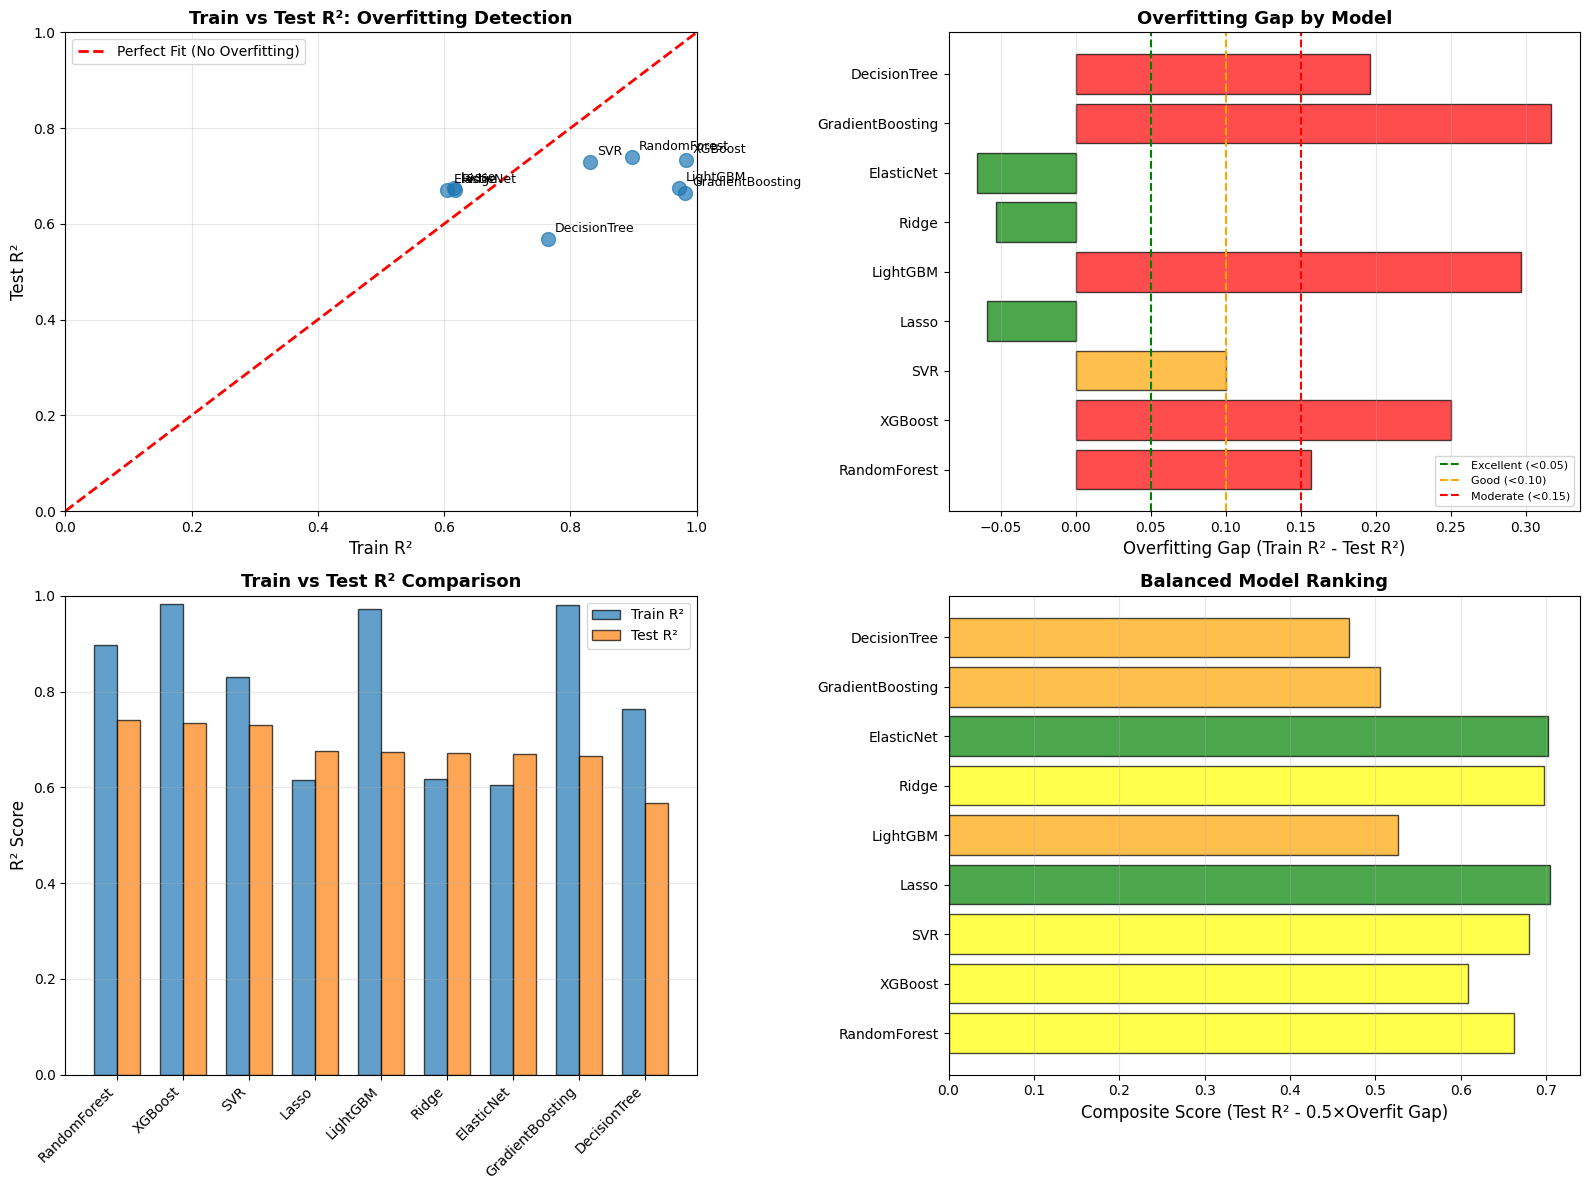


Composite Scores (Test R² - 0.5×Overfit Gap):
           Model  Test_R2  Overfit_Gap  Composite_Score
           Lasso 0.675066    -0.059130         0.704631
      ElasticNet 0.669880    -0.065786         0.702773
           Ridge 0.670755    -0.053155         0.697332
             SVR 0.730193     0.100401         0.679992
    RandomForest 0.740533     0.156854         0.662105
         XGBoost 0.733234     0.249930         0.608269
        LightGBM 0.674594     0.296980         0.526104
GradientBoosting 0.664347     0.316981         0.505856
    DecisionTree 0.567962     0.196410         0.469758


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Train vs Test R²
ax1 = axes[0, 0]
ax1.scatter(results_df['Train_R2'], results_df['Test_R2'], s=100, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    ax1.annotate(model, 
                (results_df['Train_R2'].iloc[i], results_df['Test_R2'].iloc[i]),
                fontsize=9, xytext=(5, 5), textcoords='offset points')
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (No Overfitting)', linewidth=2)
ax1.set_xlabel('Train R²', fontsize=12)
ax1.set_ylabel('Test R²', fontsize=12)
ax1.set_title('Train vs Test R²: Overfitting Detection', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot 2: Overfitting Gap
ax2 = axes[0, 1]
colors = results_df['Overfit_Gap'].apply(
    lambda x: 'green' if x < 0.05 else ('yellow' if x < 0.10 else ('orange' if x < 0.15 else 'red'))
)
ax2.barh(results_df['Model'], results_df['Overfit_Gap'], color=colors, alpha=0.7, edgecolor='black')
ax2.axvline(0.05, color='green', linestyle='--', linewidth=1.5, label='Excellent (<0.05)')
ax2.axvline(0.10, color='orange', linestyle='--', linewidth=1.5, label='Good (<0.10)')
ax2.axvline(0.15, color='red', linestyle='--', linewidth=1.5, label='Moderate (<0.15)')
ax2.set_xlabel('Overfitting Gap (Train R² - Test R²)', fontsize=12)
ax2.set_title('Overfitting Gap by Model', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Model Performance Comparison
ax3 = axes[1, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax3.bar(x_pos - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.7, edgecolor='black')
ax3.bar(x_pos + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.7, edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_title('Train vs Test R² Comparison', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 1])

# Plot 4: Composite Score (Test R² - Overfitting Penalty)
ax4 = axes[1, 1]
results_df['Composite_Score'] = results_df['Test_R2'] - (results_df['Overfit_Gap'] * 0.5)
colors_composite = results_df['Composite_Score'].apply(
    lambda x: 'green' if x > 0.7 else ('yellow' if x > 0.6 else 'orange')
)
ax4.barh(results_df['Model'], results_df['Composite_Score'], color=colors_composite, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Composite Score (Test R² - 0.5×Overfit Gap)', fontsize=12)
ax4.set_title('Balanced Model Ranking', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('trained_models/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComposite Scores (Test R² - 0.5×Overfit Gap):")
print(results_df[['Model', 'Test_R2', 'Overfit_Gap', 'Composite_Score']].sort_values('Composite_Score', ascending=False).to_string(index=False))